# Probabilistic Programming 3: Hidden Markov modeling
## Variational inference

In this notebook, we are looking at inference in a dynamical system.

### Preliminaries

- Goal 
  - Learn to apply ForneyLab to a dynamical system.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
    - [Getting started with ForneyLab](https://biaslab.github.io/forneylab/docs/getting-started/).

In [ ]:
# Package manager
using Pkg
Pkg.activate("workspace")
Pkg.instantiate()

include("../scripts/pp-3.jl")

using Logging; disable_logging(LogLevel(0))
using LinearAlgebra
using ForneyLab
using Plots
pyplot();

## Data generation

In this problem setting, data is generated in the form of states over time. For example, proteins that fold into one of several functional configurations or machine translation, where one observes writing in one language and aims to infer writing in another language (both being finite sets of symbols). We don't have perfect measurement tools and have to assume measurement noise. 

We will generate a synthetic data set as follows: we pick an initial state and evolve the state using a fixed state transition matrix. Then we observe the state using a fixed observation probability, referred to as an _emission_ matrix. 

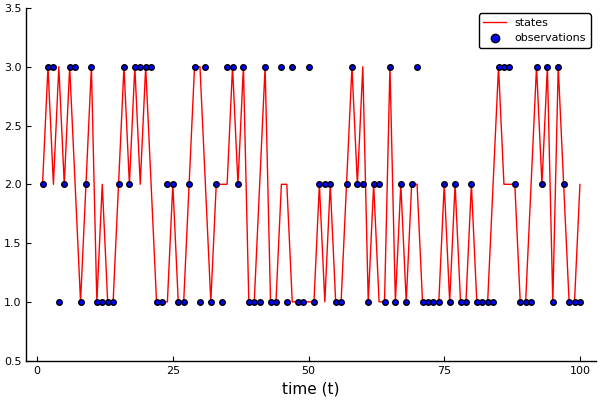

In [2]:
# Number of states
K = 3

# Length of time-series
T = 100

# Transition matrix of latent variables
transition = [0.3  0.5  0.2;
              0.6  0.2  0.7;
              0.1  0.3  0.1]

# Emission matrix for observed variables
emission = [0.8  0.2  0.1;
            0.1  0.6  0.1;
            0.1  0.2  0.8]

# Preallocate data arrays
states = Array{Int64,1}(undef, T)
observations = Array{Int64,1}(undef, T)

# Initial state
state_0 = 1

# Keep previous state in memory
state_tmin = state_0

# Generate data for entire time-series
for t = 1:T
    
    # Transition from previous state
    states[t] = sample(ProbabilityDistribution(Categorical, p=transition[:, state_tmin])).nzind[1]
    
    # Emission of current state
    observations[t] = sample(ProbabilityDistribution(Categorical, p=emission[:, states[t]])).nzind[1]
    
    # Update previous state
    state_tmin = states[t]
    
end

# Visualization.
plot(1:T, states, color="red", label="states", ylim=(0.5, 3.5), grid=false)
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

## Model Specification

The Hidden Markov model is a state-space model of the form:

$$\begin{align}
x_t \sim&\ \text{Cat}(A x_{t-1}) \\
y_t \sim&\ \text{Cat}(B x_t)
\end{align}$$

where $A$ is the state transition matrix and $B$ is the emission matrix. The states $x$ are indexed by time $t$, ranging from $0$ to $T$. The observations $y$ are indexed from $1$ to $T$. 

### Joint estimation of states, transition and emission matrices

It is possible to know the transition and emission matrices; in protein folding we know exactly _how_ the protein changes state, i.e. through the signaling of another molecule, and we know the concentration of signal molecules. However, in other applications we do not necessarily know the transition matrix. We can estimate the transition matrix by letting the coefficients be latent variables and posing a prior.

We start by initializing the graph and defining the initial state to be Categorically distributed. We then define two vectors of variables, with $x$ being the linear transition based on a previous state and $y$ being the linear transition from a state to an observation. ForneyLab has a special "Transition" node that applies a linear transformation to a variable. For this to work, the states and observations have to be in a "one-hot encoding" form: $x_i = 3 \iff x_i = [0. 0. 1.]$ for $K=3$.

In [3]:
# Map states and observations to one-hot encodings
states_1h = one_hot.(states, K)
observations_1h = one_hot.(observations, K)

100-element Array{Array{Float64,1},1}:
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 0.0, 1.0]
 [1.0, 0.0, 0.0]
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 0.0, 1.0]
 [1.0, 0.0, 0.0]
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 ⋮              
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [1.0, 0.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]

We'll use an informative prior for the emission matrix, because we think that sensor noise is relatively low, but we'll use a less informative prior for the transition matrix, because we are not sure about process noise.

In [4]:
# Initialize a graph
g = FactorGraph()

# Preallocate variable arrays (one-hot encodings)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

# Prior for initial state
@RV x_0 ~ Categorical(ones(K)/K)

# Prior for transition matrix
@RV A ~ Dirichlet(ones(K, K))

# Prior for emission matrix
@RV B ~ Dirichlet([10.0  1.0  1.0; 
                    1.0 10.0  1.0; 
                    1.0  1.0 10.0])

# Keep previous state in memory
x_tmin = x_0

# Iterate over time
for t = 1:T
    
    # State transition
    @RV x[t] ~ Transition(x_tmin, A)
    
    # Observation emission
    @RV y[t] ~ Transition(x[t], B)
    
    # Update previous state
    x_tmin = x[t]
    
    placeholder(y[t], :y, index=t, dims=(3,))
end;

Now, we construct the inference algorithm and execute it.

In [6]:
# Define the recognition factorization
q = RecognitionFactorization(A, B, [x_0; x], ids=[:A, :B, :X])

# Generate VMP algorithm
algo = variationalAlgorithm(q)

# Construct variational free energy evaluation code
algo_F = freeEnergyAlgorithm(q);

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F))

# Initialize recognition distribution marginals
marginals = Dict{Symbol, ProbabilityDistribution}()
marginals[:A] = vague(Dirichlet, (3,3))
marginals[:B] = vague(Dirichlet, (3,3))
for t = 0:T
    marginals[:x_*t] = vague(ForneyLab.Categorical, 3)
end

# Initialize data
data = Dict(:y => observations_1h)

# Number of iterations to optimize the approximation
num_iterations = 10

# Preallocate Free Energy array
F = Vector{Float64}(undef, num_iterations)

for i = 1:num_iterations
    
    # Update recognition factors
    stepX!(data, marginals)
    stepA!(data, marginals)
    stepB!(data, marginals)

    # Track Free Energy
    F[i] = freeEnergy(data, marginals)
end;

Check for convergence.

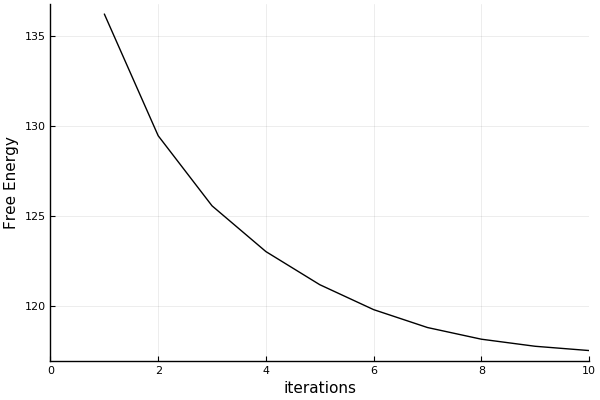

In [7]:
# Plot free energy
plot(1:num_iterations, F, color="black", label="", xlabel="iterations", ylabel="Free Energy")
xlims!(0, num_iterations)

Visualize state estimates.

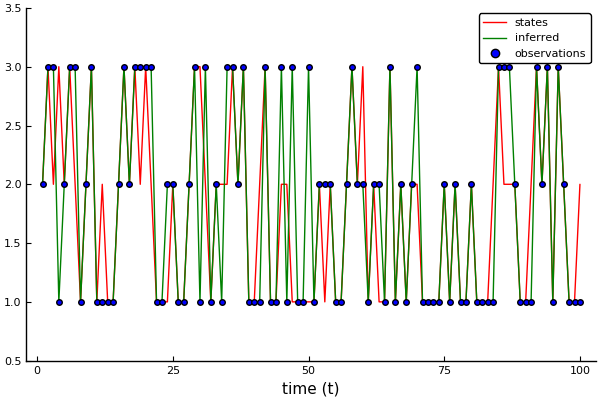

In [8]:
# Extract state estimates
states_estimated = argmax.([mean(marginals[:x_*t]) for t = 1:T])

# Visualization
plot(1:T, states, color="red", label="states", ylim=(0.5, 3.5), grid=false, xlabel="time (t)")
plot!(1:T, states_estimated, color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations")

Visualize transition matrix estimation.

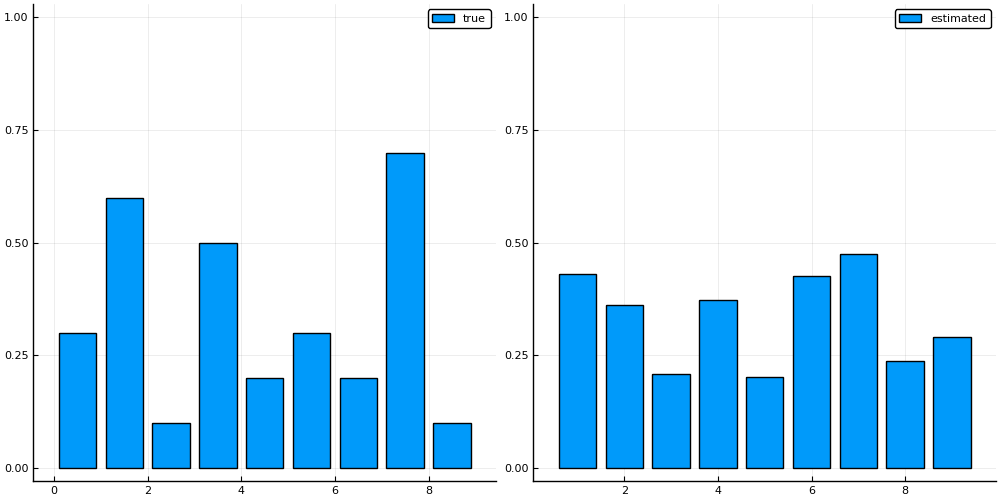

In [9]:
# Extract state estimates
transition_estimated = mean(marginals[:A])

# Visualization
l = @layout [a b]
h1 = bar(0:9, reshape(transition, (9,)), label="true", ylims=[0., 1.])
h2 = bar(reshape(transition_estimated, (9,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))

Visualize emission matrix estimation.

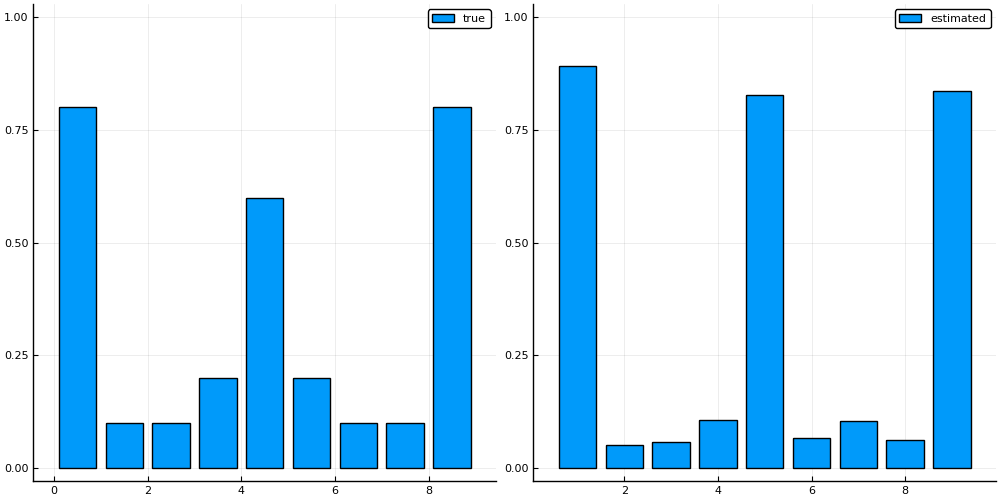

In [10]:
# Extract emission estimates
emission_estimated = mean(marginals[:B])

# Visualization
l = @layout [a b]
h1 = bar(0:9, reshape(emission, (9,)), label="true", ylims=[0., 1.])
h2 = bar(reshape(emission_estimated, (9,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))

### Assignment: change the number of states

In this assignment you need to adjust the model to handle a different number of hidden states. Specifically, observations range over 3 states while there are 2 hidden states. The cell below generates and visualizes the new data. Take the model above and adjust it to fit to the data below.

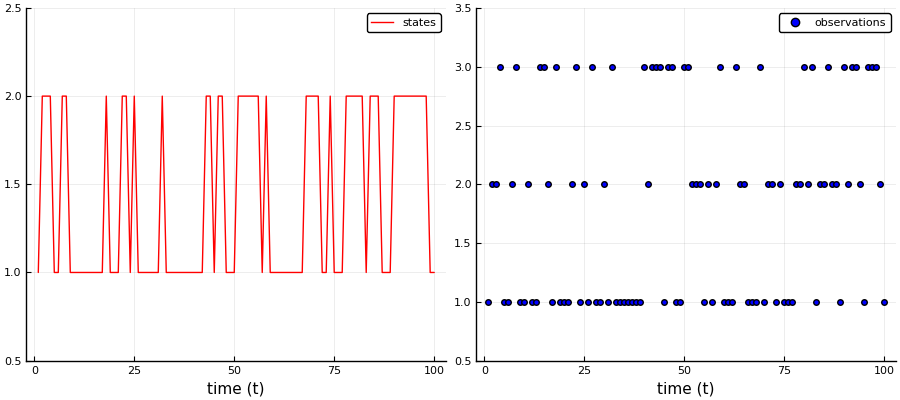

In [11]:
# Number of hidden states
K = 2

# Number of observation states
L = 3

# Length of time-series
T = 100

# Transition matrix of latent variables
transition = [0.8  0.3;
              0.2  0.7]

# Emission matrix for observed variables
emission = [0.7  0.1;
            0.1  0.6;
            0.2  0.3]

# Preallocate data arrays
states = Array{Int64,1}(undef, T)
observations = Array{Int64,1}(undef, T)

# Initial state
state_0 = 1

# Keep previous state in memory
state_tmin = state_0

# Generate data for entire time-series
for t = 1:T
    
    # Transition from previous state
    states[t] = sample(ProbabilityDistribution(Categorical, p=transition[:, state_tmin])).nzind[1]
    
    # Emission of current state
    observations[t] = sample(ProbabilityDistribution(Categorical, p=emission[:, states[t]])).nzind[1]
    
    # Update previous state
    state_tmin = states[t]
    
end

# Map states and observations to one-hot encodings
states_1h = one_hot.(states, K)
observations_1h = one_hot.(observations, L)

# Visualization.
p1 = plot(1:T, states, color="red", label="states", ylim=(0.5, K+.5), xlabel="time (t)")
p2 = scatter(1:T, observations, color="blue", label="observations", ylim=(0.5, L+.5), xlabel="time (t)")
plot(p1, p2, size=(900,400))

In [ ]:
### Your code here